# ***Import libraries***

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans



# **Data Exploration**

In [2]:
df = pd.read_csv("/content/DeliveriesDataRetracted.csv")
df.head()

,Unnamed: 0,DeliveryAddressFirstLine,DeliveryAddressSecondLine,DeliveryDate,DeliveryLat,DeliveryLon
0,0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,NaN,2025-10-11,30.052645,31.332929
1,1,مدينه نصر شارع صنعاء عماره ١ مدينه نصر,NaN,2025-10-11,30.058038,31.336041
2,2,86 ش مصطفى النحاس مدينه نصر أمام كافيه ساعه لق...,NaN,2025-10-11,30.055402,31.351077
3,3,67 شارع محمد النادي، الحي 8 - مدينة نصر,خاطئ,2025-10-11,30.056590,31.356123
4,4,مدينة نصر-٢٩ محمود سامي البارودي متفرع من حسان...,NaN,2025-10-11,30.060261,31.339112


In [3]:
df.shape

(2107, 6)

In [4]:
# Number of values per column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107 entries, 0 to 2106
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2107 non-null   int64  
 1   DeliveryAddressFirstLine   2107 non-null   object 
 2   DeliveryAddressSecondLine  673 non-null    object 
 3   DeliveryDate               2107 non-null   object 
 4   DeliveryLat                1794 non-null   float64
 5   DeliveryLon                1794 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 98.9+ KB


In [5]:
#Display name of columns
df.columns

Index(['Unnamed: 0', 'DeliveryAddressFirstLine', 'DeliveryAddressSecondLine',
       'DeliveryDate', 'DeliveryLat', 'DeliveryLon'],
      dtype='object')

In [6]:
df['DeliveryDate'].unique()


array(['2025-10-11', '2025-10-12', '2025-10-13', '2025-10-14',
       '2025-10-15', '2025-10-16'], dtype=object)

In [7]:
df['DeliveryDate'] = pd.to_datetime(df['DeliveryDate'])

In [8]:
df['DeliveryDate'].min(), df['DeliveryDate'].max()


(Timestamp('2025-10-11 00:00:00'), Timestamp('2025-10-16 00:00:00'))

In [9]:
df_15 = df[df['DeliveryDate'] == "2025-10-15"]
df_16 = df[df['DeliveryDate'] == "2025-10-16"]

print(df_15.shape)
print(df_16.shape)


(308, 6)
(313, 6)


In [10]:
#missing values
df_16[['DeliveryLat', 'DeliveryLon']].isna().sum()


,0
DeliveryLat,313
DeliveryLon,313


In [11]:
# Count null values per column
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)

Null values per column:
Unnamed: 0                      0
DeliveryAddressFirstLine        0
DeliveryAddressSecondLine    1434
DeliveryDate                    0
DeliveryLat                   313
DeliveryLon                   313
dtype: int64


In [12]:
# for col, dtype in df.dtypes.items():
#     print(f"{col} -> {dtype}")

In [13]:
# # Number of unique values per column
# print("Unique values per column:")
# print(df.nunique().sort_values(ascending=False))

In [14]:
# print("\nCategorical column statistics:")
# print(df.describe(include='object'))

In [15]:
df.head()

,Unnamed: 0,DeliveryAddressFirstLine,DeliveryAddressSecondLine,DeliveryDate,DeliveryLat,DeliveryLon
0,0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,NaN,2025-10-11,30.052645,31.332929
1,1,مدينه نصر شارع صنعاء عماره ١ مدينه نصر,NaN,2025-10-11,30.058038,31.336041
2,2,86 ش مصطفى النحاس مدينه نصر أمام كافيه ساعه لق...,NaN,2025-10-11,30.055402,31.351077
3,3,67 شارع محمد النادي، الحي 8 - مدينة نصر,خاطئ,2025-10-11,30.056590,31.356123
4,4,مدينة نصر-٢٩ محمود سامي البارودي متفرع من حسان...,NaN,2025-10-11,30.060261,31.339112


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107 entries, 0 to 2106
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 2107 non-null   int64         
 1   DeliveryAddressFirstLine   2107 non-null   object        
 2   DeliveryAddressSecondLine  673 non-null    object        
 3   DeliveryDate               2107 non-null   datetime64[ns]
 4   DeliveryLat                1794 non-null   float64       
 5   DeliveryLon                1794 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 98.9+ KB


# Task 1 Extract Meaningful Address Fields
# Cleaning Step

In [17]:
# A new DataFrame is returned with 'DeliveryAddressSecondLine' dropped; the original 'df' remains unchanged
df_new = df.drop('DeliveryAddressSecondLine', axis=1)


In [18]:
df_new.head()

,Unnamed: 0,DeliveryAddressFirstLine,DeliveryDate,DeliveryLat,DeliveryLon
0,0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,2025-10-11,30.052645,31.332929
1,1,مدينه نصر شارع صنعاء عماره ١ مدينه نصر,2025-10-11,30.058038,31.336041
2,2,86 ش مصطفى النحاس مدينه نصر أمام كافيه ساعه لق...,2025-10-11,30.055402,31.351077
3,3,67 شارع محمد النادي، الحي 8 - مدينة نصر,2025-10-11,30.056590,31.356123
4,4,مدينة نصر-٢٩ محمود سامي البارودي متفرع من حسان...,2025-10-11,30.060261,31.339112


In [19]:
def normalize_arabic(text):
    text = str(text)

    # make letter with same shape
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    text = text.replace("ى", "ي")
    text = text.replace("ة", "ه")

    # change numbers to be same in english
    arabic_numbers = "٠١٢٣٤٥٦٧٨٩"
    english_numbers = "0123456789"
    trans_table = str.maketrans(arabic_numbers, english_numbers)
    text = text.translate(trans_table)

    # Remove symbols
    text = re.sub(r"[^\u0600-\u06FF0-9\s]", " ", text)

    # Remove Spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

df_new['CleanAddress'] = df_new['DeliveryAddressFirstLine'].apply(normalize_arabic)

df_new[['DeliveryAddressFirstLine', 'CleanAddress']].head(10)


,DeliveryAddressFirstLine,CleanAddress
0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...
1,مدينه نصر شارع صنعاء عماره ١ مدينه نصر,مدينه نصر شارع صنعاء عماره 1 مدينه نصر
2,86 ش مصطفى النحاس مدينه نصر أمام كافيه ساعه لق...,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...
3,67 شارع محمد النادي، الحي 8 - مدينة نصر,67 شارع محمد النادي، الحي 8 مدينه نصر
4,مدينة نصر-٢٩ محمود سامي البارودي متفرع من حسان...,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...
5,القاهرة مدينة نصر ١٦ انور المفتى خلف طيبة مول ...,القاهره مدينه نصر 16 انور المفتي خلف طيبه مول ...
6,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...
7,عمارة ٢٣ شارع محمد النادي خلف فودافون مصطفى ال...,عماره 23 شارع محمد النادي خلف فودافون مصطفي ال...
8,مدينة نصر مصطفى النحاس ٤ محمد مقلد الدور ٩ شقة...,مدينه نصر مصطفي النحاس 4 محمد مقلد الدور 9 شقه...
9,مدينه نصر ٧ عباس العقاد دور ٦ شمال الاسانسير,مدينه نصر 7 عباس العقاد دور 6 شمال الاسانسير


# see Random Sample to determine pattern of Address

In [20]:
df_new['CleanAddress'].sample(20).values


array(['شارع', '1محمد توفيق وهبه متفرع من احمد فخري مديه نصر',
       '13 محمود غنيم احمد فخري مدينه نصر، مدينه نصر',
       'محمد طلعت سالم محمد متفرع من عباس العقاد',
       '8 شارع مصطفي رياض متفرع من البطراوي',
       '5 عباس العقاد الدور الارضي عماره فودافون بجوار كشري التحرير',
       '30 شارع لوساكا خلف احمد فخري مدينه نصر، القاهره',
       '2 شارع محمد مصطفي حمام متفرع من اول شارع عباس العقاد مدينه نصر ، الدور السابع',
       'عباس العقاد، 9 شارع عبد العظيم الغلمي الدور 3، شقه 8',
       'مدينه نصر 80 عباس العقاد الدور التاني شقه 4 القاهره الجديده',
       'مدينه نصر 27 ش محمود سامي باشا متفرع من حسين هيكل الدور 3 شقه 8 امام العماره محل حلاقه اسمه فلانتينو مصر مدينه نصر',
       '7 شارع محمندور مدينه نصر القاهره',
       '6 جمال الدين عفيفي من ابراهيم نوار من احمد فخري مدينه نصر',
       'مدينه نصر، 27 شارع احمد الصاوي 7، الطابق الرابع القاهره',
       'القاهره مدينه نصر الحي 06 مدينه نصر مكرم عبيد 62 مكرم عبيد امام حديقه الطفل اعلي بنك مدينه نصر الحي 06 مدينه نصر',
       '43 

In [ ]:
def extract_building_number(text):
    m = re.search(r"عماره\s*(\d+)", text)
    if m:
        return m.group(1)

    m = re.match(r"^\s*(\d+)\s+", text)
    if m:
        return m.group(1)

    return None


def extract_floor(text):
    m = re.search(r"الدور\s*(\w+)", text)
    if m:
        return m.group(1)
    return None


def extract_apartment(text):
    m = re.search(r"شقه\s*(\d+)", text)
    if m:
        return m.group(1)
    return None


# def extract_district(text):
#     if "مدينه نصر" in text:
#         return "مدينه نصر"

#     return None

#use this function due to data place in nasr city
def extract_district(text):
    if "مدينه نصر" in text:
        return "مدينه نصر"
    else:
        return "مدينه نصر"

def extract_area(text):
    m = re.search(r"الحي\s*(\d+)", text)
    if m:
        return f"الحي {m.group(1)}"

    m = re.search(r"المنطقه\s*(\w+)", text)
    if m:
        return f"المنطقه {m.group(1)}"

    return None


def extract_landmark(text):
    m = re.search(r"(امام|خلف|بجوار|ناصيه|قريب من)\s+(.+)", text)
    if m:
        return m.group(2).strip()
    return None


def extract_street(text):
    m = re.search(r"(شارع|ش)\s+([^\d]+)", text)
    if m:
        street = m.group(2).strip()
        street = re.split(r"(عماره|الدور|شقه|مدينه نصر|امام|خلف|بجوار)", street)[0]
        return street.strip()

    return None


In [22]:
df_new['BuildingNumber'] = df_new['CleanAddress'].apply(extract_building_number)
df_new['StreetName'] = df_new['CleanAddress'].apply(extract_street)
df_new['District'] = df_new['CleanAddress'].apply(extract_district)
df_new['AreaDetails'] = df_new['CleanAddress'].apply(extract_area)
df_new['Floor'] = df_new['CleanAddress'].apply(extract_floor)
df_new['Apartment'] = df_new['CleanAddress'].apply(extract_apartment)
df_new['Landmark'] = df_new['CleanAddress'].apply(extract_landmark)

df_new[['CleanAddress','BuildingNumber','StreetName','District','AreaDetails','Floor','Apartment','Landmark']].head(20)


,CleanAddress,BuildingNumber,StreetName,District,AreaDetails,Floor,Apartment,Landmark
0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,73,None,مدينه نصر,None,الاول,102,None
1,مدينه نصر شارع صنعاء عماره 1 مدينه نصر,1,صنعاء,مدينه نصر,None,None,None,None
2,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...,86,مصطفي النحاس,مدينه نصر,None,None,None,كافيه ساعه لقلبك و مركز النور للعيون
3,67 شارع محمد النادي، الحي 8 مدينه نصر,67,محمد النادي، الحي,مدينه نصر,الحي 8,None,None,None
4,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...,None,None,مدينه نصر,None,السادس,12,None
5,القاهره مدينه نصر 16 انور المفتي خلف طيبه مول ...,None,None,مدينه نصر,None,None,1010,طيبه مول دور العاشر شقه 1010 تحت البيت صيدليه ...
6,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...,2,None,مدينه نصر,None,التامن,81,None
7,عماره 23 شارع محمد النادي خلف فودافون مصطفي ال...,23,محمد النادي,مدينه نصر,None,None,None,فودافون مصطفي النحاس مدينه نصر 23 شارع محمد ال...
8,مدينه نصر مصطفي النحاس 4 محمد مقلد الدور 9 شقه...,None,None,مدينه نصر,None,9,17,None
9,مدينه نصر 7 عباس العقاد دور 6 شمال الاسانسير,None,None,مدينه نصر,None,None,None,None


In [23]:
#missing percentage
df_new[['BuildingNumber','StreetName','AreaDetails','Floor','Apartment','Landmark']].isna().mean()


,0
BuildingNumber,0.426673
StreetName,0.427148
AreaDetails,0.874229
Floor,0.670622
Apartment,0.699573
Landmark,0.806360


In [ ]:
stop_words = [
    "عماره", "الدور", "شقه", "الحي", "المنطقه",
    "مدينه نصر", "القاهره",
    "امام", "خلف", "بجوار", "ناصيه", "متفرع"
]

def extract_street_v2(text):
    m = re.search(r"(شارع|ش)\s+(.+)", text)
    if m:
        street = m.group(2).strip()

        for w in stop_words:
            if w in street:
                street = street.split(w)[0].strip()

        street = street.replace("،", " ").strip()
        street = re.sub(r"\s+", " ", street)

        return street if street != "" else None

    return None


In [25]:
df_new['StreetName_v2'] = df_new['CleanAddress'].apply(extract_street_v2)

df_new[['CleanAddress','StreetName','StreetName_v2']].head(30)


,CleanAddress,StreetName,StreetName_v2
0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,None,None
1,مدينه نصر شارع صنعاء عماره 1 مدينه نصر,صنعاء,صنعاء
2,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...,مصطفي النحاس,مصطفي النحاس
3,67 شارع محمد النادي، الحي 8 مدينه نصر,محمد النادي، الحي,محمد النادي
4,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...,None,None
5,القاهره مدينه نصر 16 انور المفتي خلف طيبه مول ...,None,None
6,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...,None,None
7,عماره 23 شارع محمد النادي خلف فودافون مصطفي ال...,محمد النادي,محمد النادي
8,مدينه نصر مصطفي النحاس 4 محمد مقلد الدور 9 شقه...,None,None
9,مدينه نصر 7 عباس العقاد دور 6 شمال الاسانسير,None,None


In [26]:
known_streets = [
    "عباس العقاد",
    "مصطفي النحاس",
    "مكرم عبيد",
    "احمد فخري",
    "الطيران",
    "حسنين هيكل",
    "محمد النادي",
    "انور المفتي",
    "محمد حسنين هيكل",
    "جمال الدين عفيفي"
]

def detect_known_street(text):
    for st in known_streets:
        if st in text:
            return st
    return None


In [27]:
df_new['StreetFinal'] = df_new['StreetName_v2']
df_new.loc[df_new['StreetFinal'].isna(), 'StreetFinal'] = df_new.loc[df_new['StreetFinal'].isna(), 'CleanAddress'].apply(detect_known_street)

df_new[['CleanAddress','StreetName_v2','StreetFinal']].head(30)


,CleanAddress,StreetName_v2,StreetFinal
0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,None,None
1,مدينه نصر شارع صنعاء عماره 1 مدينه نصر,صنعاء,صنعاء
2,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...,مصطفي النحاس,مصطفي النحاس
3,67 شارع محمد النادي، الحي 8 مدينه نصر,محمد النادي,محمد النادي
4,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...,None,None
5,القاهره مدينه نصر 16 انور المفتي خلف طيبه مول ...,None,انور المفتي
6,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...,None,احمد فخري
7,عماره 23 شارع محمد النادي خلف فودافون مصطفي ال...,محمد النادي,محمد النادي
8,مدينه نصر مصطفي النحاس 4 محمد مقلد الدور 9 شقه...,None,مصطفي النحاس
9,مدينه نصر 7 عباس العقاد دور 6 شمال الاسانسير,None,عباس العقاد


In [28]:
df_new['StreetFinal'].isna().mean()
df_new[['BuildingNumber','StreetName','AreaDetails','Floor','Apartment','Landmark','StreetFinal']].isna().mean()


,0
BuildingNumber,0.426673
StreetName,0.427148
AreaDetails,0.874229
Floor,0.670622
Apartment,0.699573
Landmark,0.806360
StreetFinal,0.209302


In [29]:
df_new

,Unnamed: 0,DeliveryAddressFirstLine,DeliveryDate,DeliveryLat,DeliveryLon,CleanAddress,BuildingNumber,StreetName,District,AreaDetails,Floor,Apartment,Landmark,StreetName_v2,StreetFinal
0,0,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,2025-10-11,30.052645,31.332929,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,73,None,مدينه نصر,None,الاول,102,None,None,None
1,1,مدينه نصر شارع صنعاء عماره ١ مدينه نصر,2025-10-11,30.058038,31.336041,مدينه نصر شارع صنعاء عماره 1 مدينه نصر,1,صنعاء,مدينه نصر,None,None,None,None,صنعاء,صنعاء
2,2,86 ش مصطفى النحاس مدينه نصر أمام كافيه ساعه لق...,2025-10-11,30.055402,31.351077,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...,86,مصطفي النحاس,مدينه نصر,None,None,None,كافيه ساعه لقلبك و مركز النور للعيون,مصطفي النحاس,مصطفي النحاس
3,3,67 شارع محمد النادي، الحي 8 - مدينة نصر,2025-10-11,30.056590,31.356123,67 شارع محمد النادي، الحي 8 مدينه نصر,67,محمد النادي، الحي,مدينه نصر,الحي 8,None,None,None,محمد النادي,محمد النادي
4,4,مدينة نصر-٢٩ محمود سامي البارودي متفرع من حسان...,2025-10-11,30.060261,31.339112,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...,None,None,مدينه نصر,None,السادس,12,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,2102,القاهرة مدينة نصر شارع مخلص الالفي بناية ٣٤ ال...,2025-10-16,NaN,NaN,القاهره مدينه نصر شارع مخلص الالفي بنايه 34 ال...,None,مخلص الالفي بنايه,مدينه نصر,None,1,4,None,مخلص الالفي بنايه 34,مخلص الالفي بنايه 34
2103,2103,١٢ ب محمد كامل الحارونى متفرع من احمد فخرى مدي...,2025-10-16,NaN,NaN,12 ب محمد كامل الحاروني متفرع من احمد فخري مدي...,12,None,مدينه نصر,None,None,None,None,None,احمد فخري
2104,2104,"الزهراء اسماعيل, عمارة اسمها كوين بلازا شارع ...",2025-10-16,NaN,NaN,الزهراء اسماعيل عماره اسمها كوين بلازا شارع ان...,None,انور المفتي من اول عباس العقاد القاهره,مدينه نصر,None,None,None,None,انور المفتي من اول عباس العقاد,انور المفتي من اول عباس العقاد
2105,2105,٧ مكرر عبداللطيف حمزة-مدينة نصر الدور الاول شق...,2025-10-16,NaN,NaN,7 مكرر عبداللطيف حمزه مدينه نصر الدور الاول شق...,7,None,مدينه نصر,None,الاول,102,None,None,None


In [ ]:
def extract_building_number_v2(text):
    m = re.search(r"(عماره|عمارة)\s*([0-9]+[a-zA-Z]?)", text)
    if m:
        return m.group(2)

    m = re.search(r"(مبني|مبنى)\s*([0-9]+[a-zA-Z]?)", text)
    if m:
        return m.group(2)

    m = re.search(r"(برج)\s*([0-9]+[a-zA-Z]?)", text)
    if m:
        return m.group(2)

    m = re.search(r"(بلوك)\s*([0-9]+[a-zA-Z]?)", text)
    if m:
        return m.group(2)

    m = re.match(r"^\s*([0-9]+)\s+", text)
    if m:
        return m.group(1)

    return None


In [31]:
df_new['BuildingNumber_v2'] = df_new['CleanAddress'].apply(extract_building_number_v2)
df_new['BuildingNumber_v2'].isna().mean()


np.float64(0.4186046511627907)

In [ ]:
def extract_area_v2(text):
    m = re.search(r"الحي\s*([0-9]+)", text)
    if m:
        return f"الحي {m.group(1)}"

    m = re.search(r"الحي\s*(الاول|الثاني|الثالث|الرابع|الخامس|السادس|السابع|الثامن|التاسع|العاشر)", text)
    if m:
        return f"الحي {m.group(1)}"

    m = re.search(r"المنطقه\s*([0-9]+)", text)
    if m:
        return f"المنطقه {m.group(1)}"

    m = re.search(r"المنطقه\s*(الاولى|الثانيه|الثالثه|الرابعه|الخامسه|السادسه|السابعة|الثامنه|التاسعه|العاشره)", text)
    if m:
        return f"المنطقه {m.group(1)}"

    return None


In [33]:
df_new['AreaDetails_v2'] = df_new['CleanAddress'].apply(extract_area_v2)
df_new['AreaDetails_v2'].isna().mean()


np.float64(0.9074513526340768)

In [34]:
def extract_floor_v2(text):
    m = re.search(r"(الدور|دور)\s*([0-9]+)", text)
    if m:
        return m.group(2)

    m = re.search(r"(الدور|دور)\s*(الاول|الثاني|الثالث|الرابع|الخامس|السادس|السابع|الثامن|التاسع|العاشر)", text)
    if m:
        return m.group(2)

    if "ارضي" in text or "ارضى" in text:
        return "ارضي"

    if "بدروم" in text:
        return "بدروم"

    return None


In [35]:
df_new['Floor_v2'] = df_new['CleanAddress'].apply(extract_floor_v2)
df_new['Floor_v2'].isna().mean()


np.float64(0.6905552918841955)

In [36]:
def extract_apartment_v2(text):
    m = re.search(r"(شقه|شقة)\s*([0-9]+)", text)
    if m:
        return m.group(2)

    m = re.search(r"(apt|apartment)\s*([0-9]+)", text.lower())
    if m:
        return m.group(2)

    return None


In [37]:
df_new['Apartment_v2'] = df_new['CleanAddress'].apply(extract_apartment_v2)
df_new['Apartment_v2'].isna().mean()


np.float64(0.6995728523967727)

In [38]:
def extract_landmark_v2(text):
    m = re.search(r"(امام|خلف|بجوار|ناصيه|قريب من)\s+(.+)", text)
    if m:
        landmark = m.group(2).strip()

        # cut landmark لو فيه تفاصيل عنوان تاني
        landmark = re.split(r"(الدور|شقه|عماره|شارع|مدينه نصر|الحي|المنطقه)", landmark)[0]
        landmark = landmark.strip()

        return landmark if landmark != "" else None

    return None


In [39]:
df_new['Landmark_v2'] = df_new['CleanAddress'].apply(extract_landmark_v2)
df_new['Landmark_v2'].isna().mean()


np.float64(0.8134788799240626)

In [40]:
missing_after = df_new[['BuildingNumber_v2','StreetFinal','AreaDetails_v2','Floor_v2','Apartment_v2','Landmark_v2']].isna().mean()
missing_after


,0
BuildingNumber_v2,0.418605
StreetFinal,0.209302
AreaDetails_v2,0.907451
Floor_v2,0.690555
Apartment_v2,0.699573
Landmark_v2,0.813479


In [41]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107 entries, 0 to 2106
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                2107 non-null   int64         
 1   DeliveryAddressFirstLine  2107 non-null   object        
 2   DeliveryDate              2107 non-null   datetime64[ns]
 3   DeliveryLat               1794 non-null   float64       
 4   DeliveryLon               1794 non-null   float64       
 5   CleanAddress              2107 non-null   object        
 6   BuildingNumber            1208 non-null   object        
 7   StreetName                1207 non-null   object        
 8   District                  2107 non-null   object        
 9   AreaDetails               265 non-null    object        
 10  Floor                     694 non-null    object        
 11  Apartment                 633 non-null    object        
 12  Landmark            

In [42]:
df_new = df_new.rename(columns={"Unnamed: 0": "index"})


In [43]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107 entries, 0 to 2106
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   index                     2107 non-null   int64         
 1   DeliveryAddressFirstLine  2107 non-null   object        
 2   DeliveryDate              2107 non-null   datetime64[ns]
 3   DeliveryLat               1794 non-null   float64       
 4   DeliveryLon               1794 non-null   float64       
 5   CleanAddress              2107 non-null   object        
 6   BuildingNumber            1208 non-null   object        
 7   StreetName                1207 non-null   object        
 8   District                  2107 non-null   object        
 9   AreaDetails               265 non-null    object        
 10  Floor                     694 non-null    object        
 11  Apartment                 633 non-null    object        
 12  Landmark            

# Task 2 Estimate Delivery Locations

In [44]:
df_ready = df_new[[
    'index','DeliveryDate', 'CleanAddress', 'StreetFinal', 'BuildingNumber_v2',
    'AreaDetails', 'Floor_v2', 'Apartment_v2', 'Landmark_v2',
    'DeliveryLat', 'DeliveryLon'
]].copy()

df_ready.head(10)


,index,DeliveryDate,CleanAddress,StreetFinal,BuildingNumber_v2,AreaDetails,Floor_v2,Apartment_v2,Landmark_v2,DeliveryLat,DeliveryLon
0,0,2025-10-11,القاهره مدينه نصر مساكن عثمان عماره 73 شقه 102...,None,73,None,الاول,102,None,30.052645,31.332929
1,1,2025-10-11,مدينه نصر شارع صنعاء عماره 1 مدينه نصر,صنعاء,1,None,None,None,None,30.058038,31.336041
2,2,2025-10-11,86 ش مصطفي النحاس مدينه نصر امام كافيه ساعه لق...,مصطفي النحاس,86,None,None,None,كافيه ساعه لقلبك و مركز النور للعيون,30.055402,31.351077
3,3,2025-10-11,67 شارع محمد النادي، الحي 8 مدينه نصر,محمد النادي,67,الحي 8,None,None,None,30.056590,31.356123
4,4,2025-10-11,مدينه نصر 29 محمود سامي البارودي متفرع من حسان...,None,None,None,السادس,12,None,30.060261,31.339112
5,5,2025-10-11,القاهره مدينه نصر 16 انور المفتي خلف طيبه مول ...,انور المفتي,None,None,العاشر,1010,طيبه مول دور العاشر,30.066892,31.328712
6,6,2025-10-11,مدينه نصر احمد فخري عماره 2ب اطلس الدور التامن...,احمد فخري,2,None,None,81,None,30.066869,31.348264
7,7,2025-10-11,عماره 23 شارع محمد النادي خلف فودافون مصطفي ال...,محمد النادي,23,None,None,None,فودافون مصطفي النحاس,30.055695,31.350134
8,8,2025-10-11,مدينه نصر مصطفي النحاس 4 محمد مقلد الدور 9 شقه...,مصطفي النحاس,None,None,9,17,None,30.055212,31.356465
9,9,2025-10-11,مدينه نصر 7 عباس العقاد دور 6 شمال الاسانسير,عباس العقاد,None,None,6,None,None,30.067013,31.336265


In [45]:
missing_after = df_ready[['BuildingNumber_v2','StreetFinal','AreaDetails','Floor_v2','Apartment_v2','Landmark_v2']].isna().mean()
missing_after


,0
BuildingNumber_v2,0.418605
StreetFinal,0.209302
AreaDetails,0.874229
Floor_v2,0.690555
Apartment_v2,0.699573
Landmark_v2,0.813479


# Divided Data in to part using Date

In [46]:
df_hist = df_ready[df_ready['DeliveryDate'] < "2025-10-16"].copy()
df_16 = df_ready[df_ready['DeliveryDate'] == "2025-10-16"].copy()


# Exact Match

In [47]:
street_lookup = df_hist.groupby("StreetFinal")[['DeliveryLat','DeliveryLon']].mean()

def exact_match_street(street):
    if street in street_lookup.index and street.strip() != "":
        lat = street_lookup.loc[street, 'DeliveryLat']
        lon = street_lookup.loc[street, 'DeliveryLon']
        return lat, lon, 95
    return None, None, 0

df_16[['PredLat','PredLon','Confidence']] = df_16['StreetFinal'].apply(
    lambda x: pd.Series(exact_match_street(x))
)

df_16[['CleanAddress','StreetFinal','PredLat','PredLon','Confidence']].head(20)


,CleanAddress,StreetFinal,PredLat,PredLon,Confidence
1794,4 شارع الشيخ محمد النادي، حي مدينه نصر، محافظه...,الشيخ محمد النادي حي,NaN,NaN,0.0
1795,47 ا عباس العقاد شارع الطابق الثالث فوق بنك مصر,الطابق الثالث فوق بنك مصر,NaN,NaN,0.0
1796,24 ، انور المفتي، علي ناصيه العماره بجوار المم...,انور المفتي,30.066957,31.331762,95.0
1797,8 ش الربيع متفرع من شارع الطيران الدور السادس ...,الربيع,NaN,NaN,0.0
1798,117 شارع محمود غنيم مدينه نصر,محمود غنيم,30.063594,31.354619,95.0
1799,6 شارع وهران رابعه العدويه مدينه نصر,وهران رابعه العدويه,NaN,NaN,0.0
1800,4 معز الدوله مكرم عبيد مدينه نصر الدور 3 شقه 3,مكرم عبيد,30.060848,31.346469,95.0
1801,7 شارع الحقيقه المنطقه الاولي م نصر اخر شارع ا...,الحقيقه,30.060881,31.328294,95.0
1802,29 عبد الرحمن صدقي الدور الارضي صيدليه د رانيا...,مكرم عبيد,30.060848,31.346469,95.0
1803,مدينه نصر الاسم حسين هاشم العنوان 15 شارع قورش...,قورش,30.059819,31.342293,95.0


# Similarity Match

In [48]:
# date of day 16
hist_texts = df_hist['CleanAddress'].fillna("").tolist()
day16_texts = df_16['CleanAddress'].fillna("").tolist()

# TF-IDF
vectorizer = TfidfVectorizer()
X_hist = vectorizer.fit_transform(hist_texts)
X_16 = vectorizer.transform(day16_texts)

# Cosine similarity
sim_matrix = cosine_similarity(X_16, X_hist)

best_match_idx = np.argmax(sim_matrix, axis=1)
best_match_score = np.max(sim_matrix, axis=1)

#  predictions for unmatched
for i in range(len(df_16)):
    if df_16.iloc[i]['Confidence'] == 0:
        idx = best_match_idx[i]
        score = best_match_score[i]
        matched_lat = df_hist.iloc[idx]['DeliveryLat']
        matched_lon = df_hist.iloc[idx]['DeliveryLon']
        conf = int(score * 100)  # confidence 0-100
        df_16.at[df_16.index[i], 'PredLat'] = matched_lat
        df_16.at[df_16.index[i], 'PredLon'] = matched_lon
        df_16.at[df_16.index[i], 'Confidence'] = conf

df_16[['CleanAddress','StreetFinal','PredLat','PredLon','Confidence']].head(20)


,CleanAddress,StreetFinal,PredLat,PredLon,Confidence
1794,4 شارع الشيخ محمد النادي، حي مدينه نصر، محافظه...,الشيخ محمد النادي حي,30.055872,31.347748,66.0
1795,47 ا عباس العقاد شارع الطابق الثالث فوق بنك مصر,الطابق الثالث فوق بنك مصر,30.058427,31.337428,64.0
1796,24 ، انور المفتي، علي ناصيه العماره بجوار المم...,انور المفتي,30.066957,31.331762,95.0
1797,8 ش الربيع متفرع من شارع الطيران الدور السادس ...,الربيع,30.059406,31.327439,62.0
1798,117 شارع محمود غنيم مدينه نصر,محمود غنيم,30.063594,31.354619,95.0
1799,6 شارع وهران رابعه العدويه مدينه نصر,وهران رابعه العدويه,30.065533,31.326743,56.0
1800,4 معز الدوله مكرم عبيد مدينه نصر الدور 3 شقه 3,مكرم عبيد,30.060848,31.346469,95.0
1801,7 شارع الحقيقه المنطقه الاولي م نصر اخر شارع ا...,الحقيقه,30.060881,31.328294,95.0
1802,29 عبد الرحمن صدقي الدور الارضي صيدليه د رانيا...,مكرم عبيد,30.060848,31.346469,95.0
1803,مدينه نصر الاسم حسين هاشم العنوان 15 شارع قورش...,قورش,30.059819,31.342293,95.0


In [49]:
df_16['Confidence'].describe()



,Confidence
count,313.000000
mean,79.776358
std,20.029173
min,31.000000
25%,62.000000
50%,95.000000
75%,95.000000
max,100.000000


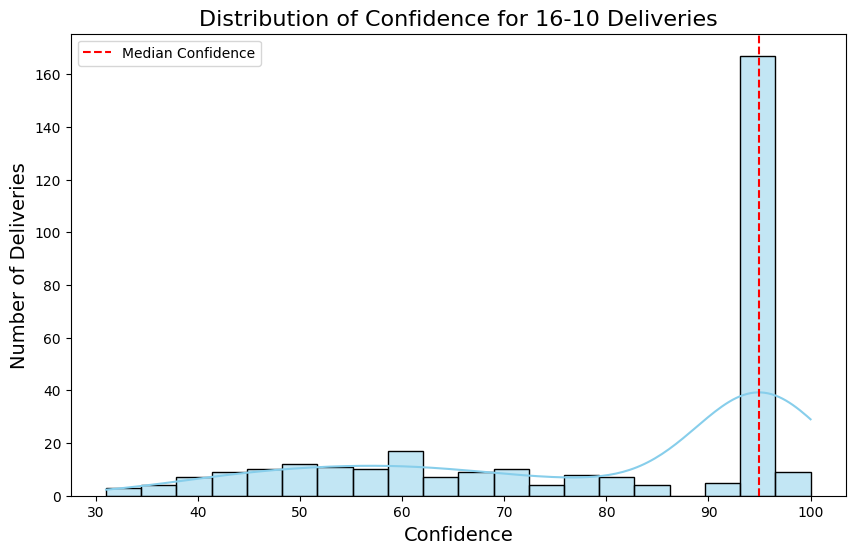

In [50]:
plt.figure(figsize=(10,6))
sns.histplot(df_16['Confidence'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Confidence for 16-10 Deliveries', fontsize=16)
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Number of Deliveries', fontsize=14)
plt.axvline(df_16['Confidence'].median(), color='red', linestyle='--', label='Median Confidence')
plt.legend()
plt.show()


In [51]:
#  centroid
street_centroid = df_hist.groupby('StreetFinal')[['DeliveryLat','DeliveryLon']].mean()

# make fallback for all delivery confidence < 50
for idx, row in df_16.iterrows():
    if row['Confidence'] < 50:
        street = row['StreetFinal']
        if street in street_centroid.index:
            df_16.at[idx, 'PredLat'] = street_centroid.loc[street, 'DeliveryLat']
            df_16.at[idx, 'PredLon'] = street_centroid.loc[street, 'DeliveryLon']
            df_16.at[idx, 'Confidence'] = 50  # minimum confidence after fallback

# نعرض النتائج
df_16[['CleanAddress','StreetFinal','PredLat','PredLon','Confidence']].head(20)


,CleanAddress,StreetFinal,PredLat,PredLon,Confidence
1794,4 شارع الشيخ محمد النادي، حي مدينه نصر، محافظه...,الشيخ محمد النادي حي,30.055872,31.347748,66.0
1795,47 ا عباس العقاد شارع الطابق الثالث فوق بنك مصر,الطابق الثالث فوق بنك مصر,30.058427,31.337428,64.0
1796,24 ، انور المفتي، علي ناصيه العماره بجوار المم...,انور المفتي,30.066957,31.331762,95.0
1797,8 ش الربيع متفرع من شارع الطيران الدور السادس ...,الربيع,30.059406,31.327439,62.0
1798,117 شارع محمود غنيم مدينه نصر,محمود غنيم,30.063594,31.354619,95.0
1799,6 شارع وهران رابعه العدويه مدينه نصر,وهران رابعه العدويه,30.065533,31.326743,56.0
1800,4 معز الدوله مكرم عبيد مدينه نصر الدور 3 شقه 3,مكرم عبيد,30.060848,31.346469,95.0
1801,7 شارع الحقيقه المنطقه الاولي م نصر اخر شارع ا...,الحقيقه,30.060881,31.328294,95.0
1802,29 عبد الرحمن صدقي الدور الارضي صيدليه د رانيا...,مكرم عبيد,30.060848,31.346469,95.0
1803,مدينه نصر الاسم حسين هاشم العنوان 15 شارع قورش...,قورش,30.059819,31.342293,95.0


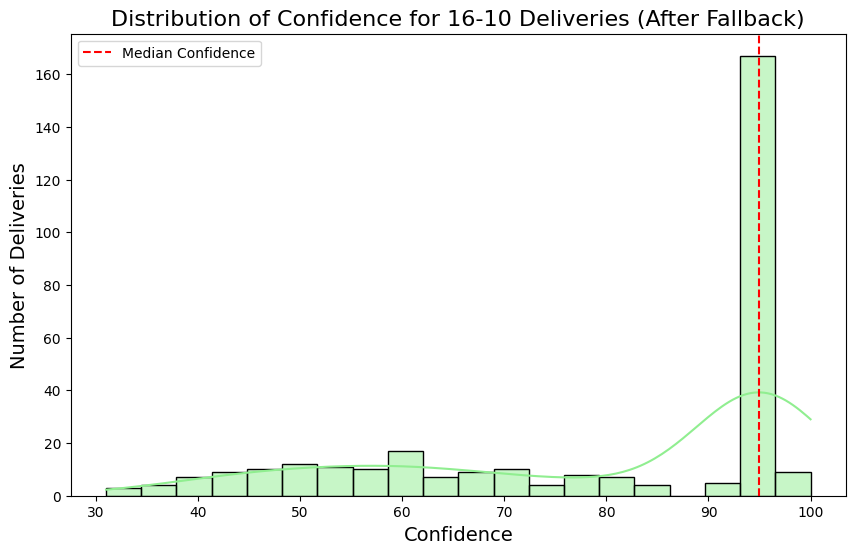

In [52]:
plt.figure(figsize=(10,6))
sns.histplot(df_16['Confidence'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Confidence for 16-10 Deliveries (After Fallback)', fontsize=16)
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Number of Deliveries', fontsize=14)
plt.axvline(df_16['Confidence'].median(), color='red', linestyle='--', label='Median Confidence')
plt.legend()
plt.show()


In [53]:
df_16_final = df_16[['CleanAddress', 'StreetFinal', 'PredLat', 'PredLon', 'Confidence']].copy()

df_16_final.head(10)


,CleanAddress,StreetFinal,PredLat,PredLon,Confidence
1794,4 شارع الشيخ محمد النادي، حي مدينه نصر، محافظه...,الشيخ محمد النادي حي,30.055872,31.347748,66.0
1795,47 ا عباس العقاد شارع الطابق الثالث فوق بنك مصر,الطابق الثالث فوق بنك مصر,30.058427,31.337428,64.0
1796,24 ، انور المفتي، علي ناصيه العماره بجوار المم...,انور المفتي,30.066957,31.331762,95.0
1797,8 ش الربيع متفرع من شارع الطيران الدور السادس ...,الربيع,30.059406,31.327439,62.0
1798,117 شارع محمود غنيم مدينه نصر,محمود غنيم,30.063594,31.354619,95.0
1799,6 شارع وهران رابعه العدويه مدينه نصر,وهران رابعه العدويه,30.065533,31.326743,56.0
1800,4 معز الدوله مكرم عبيد مدينه نصر الدور 3 شقه 3,مكرم عبيد,30.060848,31.346469,95.0
1801,7 شارع الحقيقه المنطقه الاولي م نصر اخر شارع ا...,الحقيقه,30.060881,31.328294,95.0
1802,29 عبد الرحمن صدقي الدور الارضي صيدليه د رانيا...,مكرم عبيد,30.060848,31.346469,95.0
1803,مدينه نصر الاسم حسين هاشم العنوان 15 شارع قورش...,قورش,30.059819,31.342293,95.0


# Task 3 Optimize Shipment Distribution to Couriers



In [54]:
df_15 = df_ready[df_ready['DeliveryDate'] == "2025-10-15"].copy()
df_15 = df_15[['CleanAddress','StreetFinal','DeliveryLat','DeliveryLon']].reset_index(drop=True)
df_15.shape  # must be 308


(308, 4)

In [55]:
#  Lat/Lon
X = df_15[['DeliveryLat','DeliveryLon']].values

# KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)
df_15['Courier'] = kmeans.fit_predict(X)

#   Convex Hull Area
def latlon_to_km(lat1, lon1, lat2, lon2):
    #  deg lat ~ 111 km, 1 deg lon ~ cos(lat)*111 km
    lat_avg = np.mean([lat1, lat2])
    km_lat = 111 * abs(lat1 - lat2)
    km_lon = 111 * np.cos(np.radians(lat_avg)) * abs(lon1 - lon2)
    return km_lat * km_lon

# courier areas
courier_areas = []
for c in range(20):
    cluster_points = df_15[df_15['Courier'] == c][['DeliveryLat','DeliveryLon']].values
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        coords = cluster_points[hull.vertices]
        lat_min, lon_min = coords.min(axis=0)
        lat_max, lon_max = coords.max(axis=0)
        area_km2 = latlon_to_km(lat_min, lon_min, lat_max, lon_max)
    else:
        area_km2 = 0.01
    courier_areas.append(area_km2)

total_area = sum(courier_areas)
print("Total Operational Area (km²):", total_area)


Total Operational Area (km²): 3.0786328780785874


/tmp/ipython-input-3111802845.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


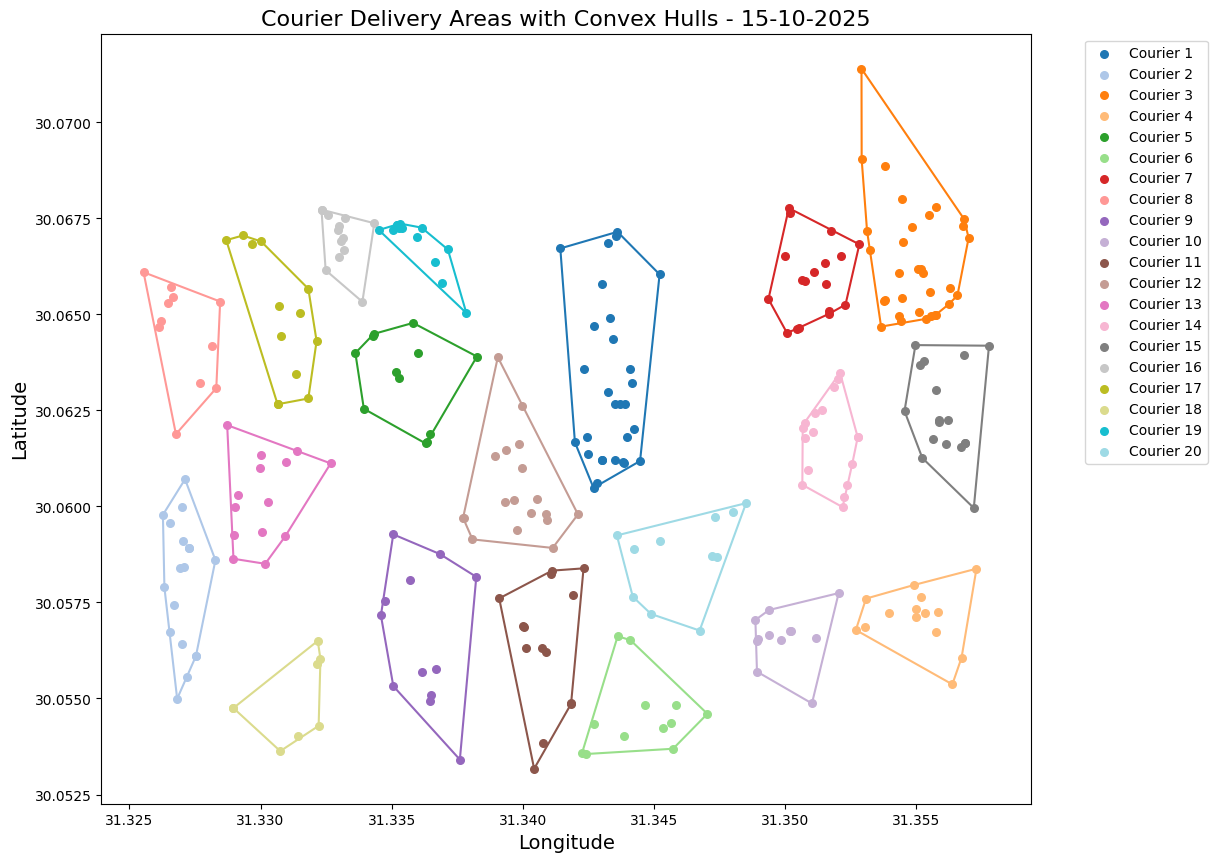

In [56]:
plt.figure(figsize=(12,10))

colors = plt.cm.get_cmap('tab20', 20)

for c in range(20):
    cluster_points = df_15[df_15['Courier']==c][['DeliveryLat','DeliveryLon']].values
    if len(cluster_points) == 0:
        continue

    #  deliveries point
    plt.scatter(cluster_points[:,1], cluster_points[:,0], color=colors(c), label=f'Courier {c+1}', s=30)

    #  convex hull
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex,1], cluster_points[simplex,0], color=colors(c))

plt.title('Courier Delivery Areas with Convex Hulls - 15-10-2025', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [57]:
df_15['Courier'].value_counts().sort_values()


,count
Courier,
17,8
19,11
7,11
8,12
5,12
9,12
4,12
18,13
15,13


In [58]:
counts = df_15['Courier'].value_counts()

print("Min deliveries per courier:", counts.min())
print("Max deliveries per courier:", counts.max())

# couriers with worng number of orders
violations = counts[(counts < 10) | (counts > 20)]
violations


Min deliveries per courier: 8
Max deliveries per courier: 32


,count
Courier,
2,32
0,29
17,8


In [59]:
df_balanced = df_15.copy()

def get_centroid(df, courier_id):
    pts = df[df["Courier"] == courier_id][["DeliveryLat", "DeliveryLon"]].values
    return pts.mean(axis=0)

def distance(point, centroid):
    return np.linalg.norm(point - centroid)

# repeat until all condation become true
max_iters = 2000

for _ in range(max_iters):

    counts = df_balanced["Courier"].value_counts()

    over = counts[counts > 20]
    under = counts[counts < 10]

    # if nothing worng -> stop
    if len(over) == 0 and len(under) == 0:
        break

    if len(over) > 0:
        over_courier = over.index[0]
    else:
        break

    can_receive = counts[counts < 20].index.tolist()

    if len(can_receive) == 0:
        break

    over_centroid = get_centroid(df_balanced, over_courier)

    over_points = df_balanced[df_balanced["Courier"] == over_courier].copy()
    over_points["dist_from_centroid"] = over_points.apply(
        lambda row: distance(np.array([row["DeliveryLat"], row["DeliveryLon"]]), over_centroid),
        axis=1
    )

    move_idx = over_points.sort_values("dist_from_centroid", ascending=False).index[0]

    point = df_balanced.loc[move_idx, ["DeliveryLat", "DeliveryLon"]].values

    best_target = None
    best_dist = 1e9

    priority_targets = under.index.tolist() + [c for c in can_receive if c not in under.index]

    for target in priority_targets:
        target_centroid = get_centroid(df_balanced, target)
        d = distance(point, target_centroid)

        if d < best_dist:
            best_dist = d
            best_target = target

    df_balanced.at[move_idx, "Courier"] = best_target


final_counts = df_balanced["Courier"].value_counts().sort_values()
print(final_counts)

print("\nMin deliveries per courier:", final_counts.min())
print("Max deliveries per courier:", final_counts.max())


Courier
17     8
7     11
4     12
8     12
9     12
5     12
15    13
16    13
19    13
12    14
10    14
18    18
3     18
1     18
14    20
11    20
6     20
0     20
2     20
13    20
Name: count, dtype: int64

Min deliveries per courier: 8
Max deliveries per courier: 20


In [60]:
def get_centroid(df, courier_id):
    pts = df[df["Courier"] == courier_id][["DeliveryLat", "DeliveryLon"]].values
    return pts.mean(axis=0)

def dist(point, centroid):
    return np.linalg.norm(point - centroid)

target = 17

while df_balanced["Courier"].value_counts()[target] < 10:

    target_centroid = get_centroid(df_balanced, target)

    donors = df_balanced["Courier"].value_counts()
    donors = donors[donors > 10].index.tolist()

    best_idx = None
    best_donor = None
    best_distance = 1e9

    for d in donors:
        donor_points = df_balanced[df_balanced["Courier"] == d]

        for idx, row in donor_points.iterrows():
            point = np.array([row["DeliveryLat"], row["DeliveryLon"]])
            d_to_target = dist(point, target_centroid)

            if d_to_target < best_distance:
                best_distance = d_to_target
                best_idx = idx
                best_donor = d

    df_balanced.at[best_idx, "Courier"] = target

print(df_balanced["Courier"].value_counts().sort_values())
print("\nMin:", df_balanced["Courier"].value_counts().min())
print("Max:", df_balanced["Courier"].value_counts().max())


Courier
17    10
7     11
4     12
8     12
9     12
5     12
16    13
12    13
19    13
15    13
10    14
1     17
3     18
18    18
14    20
11    20
6     20
0     20
2     20
13    20
Name: count, dtype: int64

Min: 10
Max: 20


In [61]:
# 1)  prepare data (Lat/Lon)
X = df_15[['DeliveryLat','DeliveryLon']].values

# 2) KMeans (20 Courier)
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
df_15['Courier'] = kmeans.fit_predict(X)

# 3) change data Lat/Lon
def approx_area_km2(lat_min, lon_min, lat_max, lon_max):
    lat_avg = (lat_min + lat_max) / 2

    dlat = abs(lat_max - lat_min)
    dlon = abs(lon_max - lon_min)

    # cahnge to km
    km_lat = 111 * dlat
    km_lon = 111 * np.cos(np.radians(lat_avg)) * dlon

    return km_lat * km_lon

# 4)   Courier

courier_areas = []

for c in range(20):
    cluster_points = df_15[df_15['Courier'] == c][['DeliveryLat','DeliveryLon']].values

    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        coords = cluster_points[hull.vertices]

        lat_min, lon_min = coords.min(axis=0)
        lat_max, lon_max = coords.max(axis=0)

        area_km2 = approx_area_km2(lat_min, lon_min, lat_max, lon_max)

    else:
        area_km2 = 0.01  # cluster

    courier_areas.append(area_km2)

# 5) Total Operational Area
total_area = sum(courier_areas)

print("Courier Areas (km²):")
for i, area in enumerate(courier_areas):
    print(f"Courier {i}: {area:.4f} km²")

print("\nTotal Operational Area (km²):", total_area)


Courier Areas (km²):
Courier 0: 0.2129 km²
Courier 1: 0.1660 km²
Courier 2: 0.1661 km²
Courier 3: 0.1774 km²
Courier 4: 0.1640 km²
Courier 5: 0.1123 km²
Courier 6: 0.1477 km²
Courier 7: 0.1968 km²
Courier 8: 0.1883 km²
Courier 9: 0.2077 km²
Courier 10: 0.1588 km²
Courier 11: 0.1151 km²
Courier 12: 0.1452 km²
Courier 13: 0.1698 km²
Courier 14: 0.1183 km²
Courier 15: 0.2852 km²
Courier 16: 0.0632 km²
Courier 17: 0.2451 km²
Courier 18: 0.1016 km²
Courier 19: 0.0465 km²

Total Operational Area (km²): 3.188113281684103


/tmp/ipython-input-1774749134.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


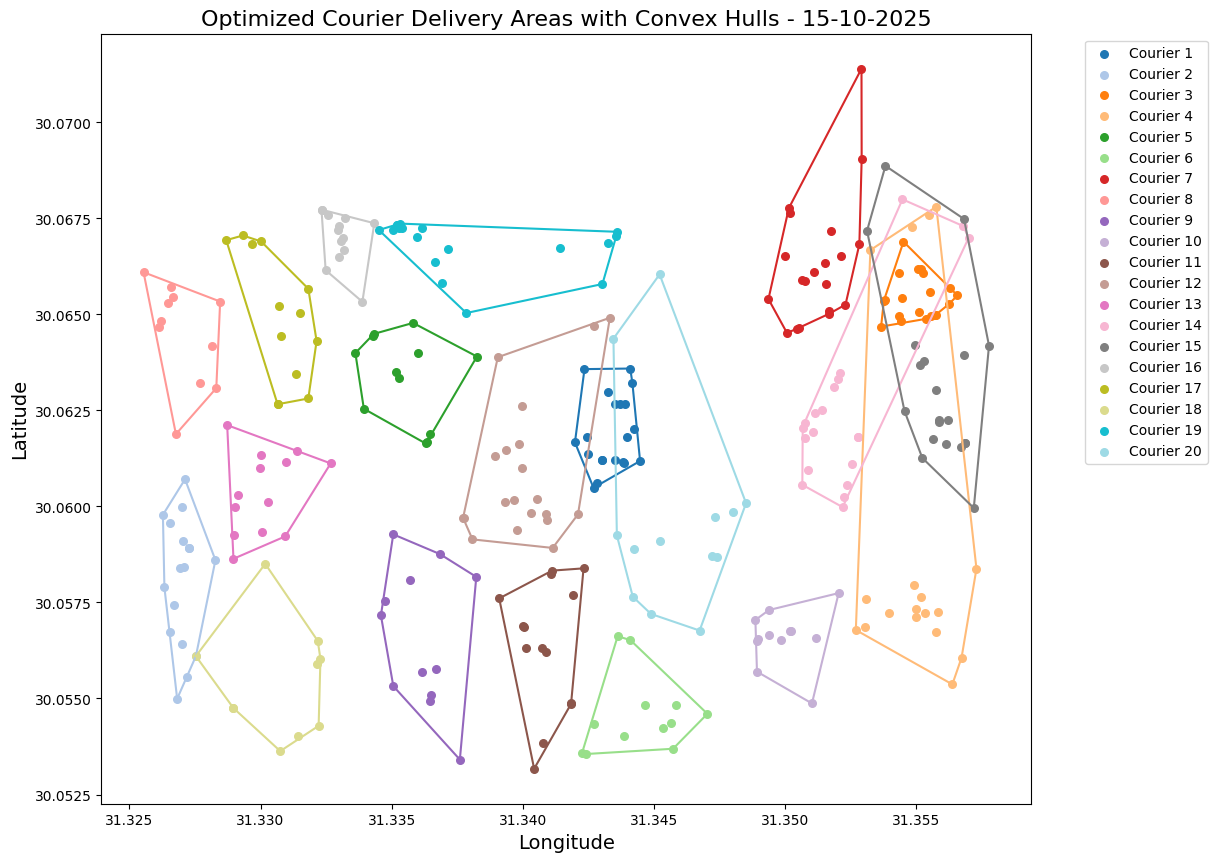

In [62]:
plt.figure(figsize=(12,10))
colors = plt.cm.get_cmap('tab20', 20)

for c in range(20):
    cluster_points = df_balanced[df_balanced['Courier']==c][['DeliveryLat','DeliveryLon']].values
    if len(cluster_points) == 0:
        continue
    # Plot deliveries
    plt.scatter(cluster_points[:,1], cluster_points[:,0], color=colors(c), label=f'Courier {c+1}', s=30)
    # Convex hull
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex,1], cluster_points[simplex,0], color=colors(c))

plt.title('Optimized Courier Delivery Areas with Convex Hulls - 15-10-2025', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Alternative Optimization Attempt (Not Used in Final Assignment)

In [63]:
df_opt = df_15.copy()
X = df_opt[['DeliveryLat','DeliveryLon']].values

# KMeans clustering
kmeans = KMeans(n_clusters=20, random_state=42)
df_opt['Courier'] = kmeans.fit_predict(X)

for iteration in range(5):
    counts = df_opt['Courier'].value_counts()
    for c in counts.index:
        if counts[c] > 20:
            cluster_points = df_opt[df_opt['Courier']==c]
            centroid = cluster_points[['DeliveryLat','DeliveryLon']].mean().values
            distances = np.linalg.norm(cluster_points[['DeliveryLat','DeliveryLon']].values - centroid, axis=1)
            farthest_idx = cluster_points.index[np.argmax(distances)]

            courier_counts = df_opt['Courier'].value_counts()
            underfilled = courier_counts[courier_counts<20].index.tolist()
            if underfilled:
                other_c = min(underfilled, key=lambda oc: np.linalg.norm(centroid - df_opt[df_opt['Courier']==oc][['DeliveryLat','DeliveryLon']].mean().values))
                df_opt.at[farthest_idx,'Courier'] = other_c
        elif counts[c] < 10:
            continue


In [64]:
def latlon_to_km(lat1, lon1, lat2, lon2):
    lat_avg = np.mean([lat1, lat2])
    km_lat = 111 * abs(lat1 - lat2)
    km_lon = 111 * np.cos(np.radians(lat_avg)) * abs(lon1 - lon2)
    return km_lat * km_lon

courier_areas = []
for c in range(20):
    cluster_points = df_opt[df_opt['Courier']==c][['DeliveryLat','DeliveryLon']].values
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        coords = cluster_points[hull.vertices]
        lat_min, lon_min = coords.min(axis=0)
        lat_max, lon_max = coords.max(axis=0)
        area_km2 = latlon_to_km(lat_min, lon_min, lat_max, lon_max)
    else:
        area_km2 = 0.01
    courier_areas.append(area_km2)

total_area = sum(courier_areas)
print("Total Operational Area (km²) after optimization:", total_area)


Total Operational Area (km²) after optimization: 3.9126366184259873


/tmp/ipython-input-2969825863.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)


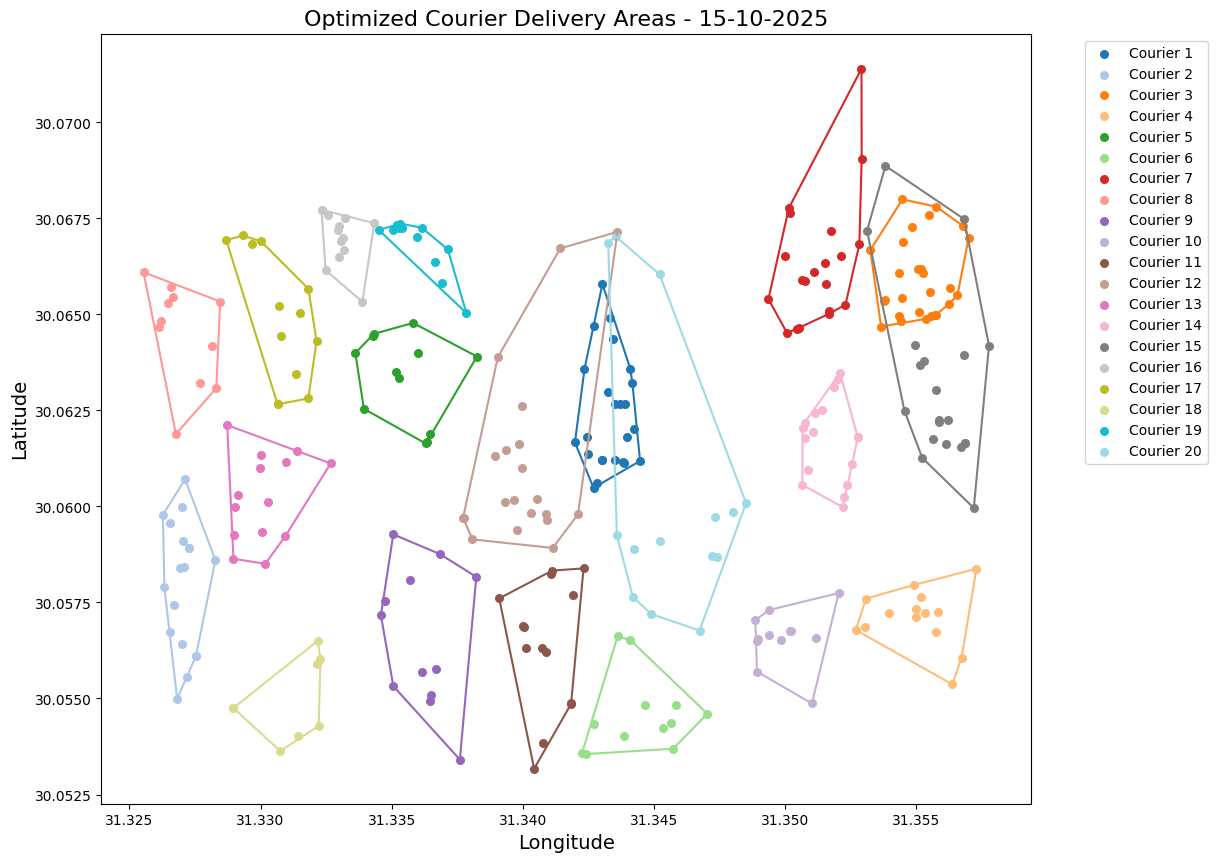

In [65]:
plt.figure(figsize=(12,10))
colors = plt.cm.get_cmap('tab20', 20)

for c in range(20):
    cluster_points = df_opt[df_opt['Courier']==c][['DeliveryLat','DeliveryLon']].values
    if len(cluster_points)==0: continue
    plt.scatter(cluster_points[:,1], cluster_points[:,0], color=colors(c), s=30, label=f'Courier {c+1}')
    if len(cluster_points) >=3:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex,1], cluster_points[simplex,0], color=colors(c))

plt.title('Optimized Courier Delivery Areas - 15-10-2025', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [66]:
df_16_output = df_16.copy()

df_16_output['DeliveryLat'] = df_16_output['PredLat']
df_16_output['DeliveryLon'] = df_16_output['PredLon']

df_16_output_final = df_16_output[[
    'index', 'DeliveryDate', 'CleanAddress',
    'BuildingNumber_v2', 'StreetFinal',
    'AreaDetails', 'Floor_v2', 'Apartment_v2', 'Landmark_v2',
    'DeliveryLat', 'DeliveryLon', 'Confidence'
]]

df_16_output_final.to_csv("Deliveries_16_10_PredictedLocations.csv", index=False)

print("CSV saved successfully!")


CSV saved successfully!
